In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [28]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
import requests
import csv

CSV_URL = 'https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_1h.csv'

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    res = csv.reader(decoded_content.splitlines(), delimiter=',')
    BTC_list = list(res)
    
    BTC_df = pd.DataFrame(data=BTC_list[2:], columns=BTC_list[1])

ConnectionError: HTTPSConnectionPool(host='www.cryptodatadownload.com', port=443): Max retries exceeded with url: /cdd/Bitfinex_BTCUSD_1h.csv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024B6EFEFB50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [15]:
root_path = 'btc_ohlc_Oct_2015_to_Oct_2021.csv'

# btc_input_df = pd.read_csv(root_path, nrows=500)
BTC_df = pd.read_csv(root_path)
BTC_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [16]:
BTC_df.columns

Index(['time', 'low', 'high', 'open', 'close', 'volume'], dtype='object')

In [9]:
for column in BTC_df.columns[3:]:
    BTC_df[column] = BTC_df[column].astype('float')
BTC_df.dtypes

time       object
low       float64
high      float64
open      float64
close     float64
volume    float64
dtype: object

In [10]:
BTC_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [11]:
BTC_df.rename(columns = {'date' : 'time'}, inplace = True) 

In [12]:
BTC_df.set_index("unix", inplace=True)
BTC_df = BTC_df[::-1]
BTC_df.reset_index(inplace=True)
BTC_df.drop("unix", axis=1, inplace=True)
BTC_df.drop("symbol", axis=1, inplace=True)

#  BTC_df['date'] = pd.to_datetime(BTC_df['date'])

BTC_df

KeyError: "None of ['unix'] are in the columns"

In [18]:
BTC_df['time'] = BTC_df['time'].astype({'time': 'datetime64'})

In [19]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='time'>

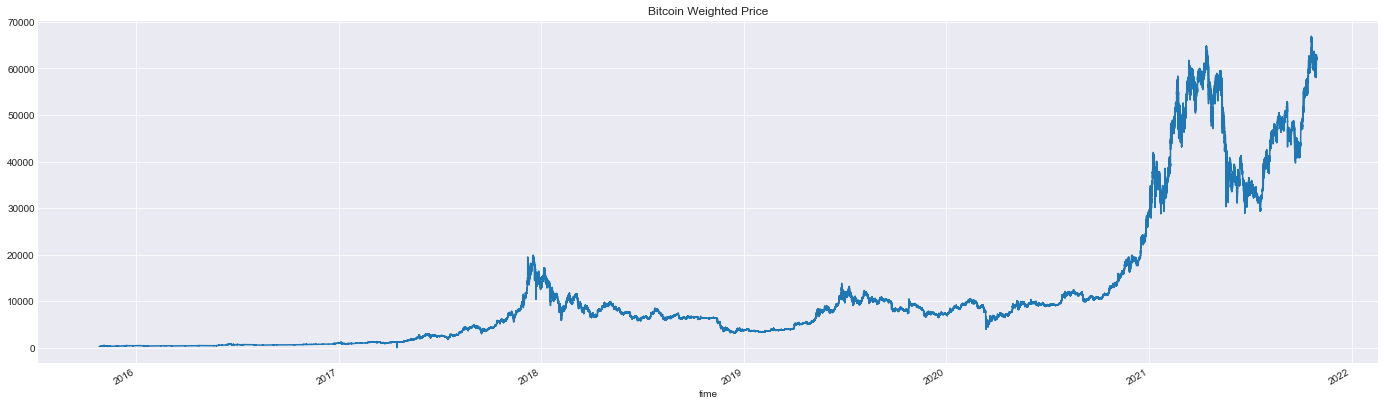

In [20]:
BTC_df.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [21]:
BTC_df['date'] = pd.to_datetime(BTC_df['time'], unit='s').dt.date

display(BTC_df.head())

group = BTC_df.groupby('date')

BTC_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [22]:
BTC_df.drop('date', axis=1, inplace=True)
BTC_df.drop('time', axis=1, inplace=True)

In [23]:
prediction_days = 60

df_train = BTC_df[len(BTC_closing_price_groupby_date) - prediction_days:].values.reshape(-1,1)


df_test = BTC_df[:len(BTC_closing_price_groupby_date) - prediction_days].values.reshape(-1,1)

In [24]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [25]:
def dataset_generator_lstm(dataset, look_back=5):
    X_data, y_data = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        X_data.append(window_size_x)
        y_data.append(dataset[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

X_train, y_train = dataset_generator_lstm(scaled_train)

X_test, y_test = dataset_generator_lstm(scaled_test)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (15555695, 5)
y_train:  (15555695,)
X_test:  (10675, 5)
y_test (10675,)


In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of trainX: ", X_train.shape)
print("Shape of testX: ", X_test.shape)

Shape of trainX:  (15555695, 5, 1)
Shape of testX:  (10675, 5, 1)


In [29]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 64, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_4 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_6 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)               

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping, PlotLossesKeras()]

history = regressor.fit(X_train,
                        y_train,
                        batch_size = 32,
                        epochs = 600,
                        verbose=1,
                        shuffle=False,
                        validation_split = 0.1,
                        callbacks=callbacks)

Epoch 1/600
   658/437504 [..............................] - ETA: 7:05:23 - loss: 0.0280 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(X_test)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [ ]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(y_train.reshape(-1, 1))